# Segmentation

## Importing dependencies

In [1]:
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt
import openslide as op
from PIL import Image
from scipy import misc
import os
import time
import h5py
import configparser
import ast
from util import mkdirs, extend_glob, file_suffix, remove_small_regions
from skimage.util import view_as_blocks

Using TensorFlow backend.


## Configuration

In [2]:
config = configparser.RawConfigParser(interpolation=configparser.ExtendedInterpolation())
config.read('cytonet.cfg')
section = 'segmentation'

In [3]:
# Paths
filenames = ast.literal_eval(config.get(section, 'filenames'))
mask_pattern = config.get(section, 'mask_pattern')
matrice_file = h5py.File(config.get(section, 'matrice_file') if config.has_option(section, 'matrice_file') \
                         else config.get('saving', 'output_file'),'r')
output_pattern= config.get(section, 'output_pattern')

experiment_folder = config.get(section, 'experiment_folder') if config.has_option(section, 'experiment_folder') \
                    else config.get('general', 'experiment_folder')
model_name = os.path.join(experiment_folder,  "matrices/" , 'model.099.hdf5')

load_level=config.getint(section, 'load_level') if config.has_option(section, 'load_level') else config.getint('general', 'load_level')
patch_size = config.getint(section, 'patch_size') if config.has_option(section, 'patch_size') else config.getint('general', 'patch_size')
stride = eval(config.get(section, 'stride'))
use_training_norm = config.getboolean(section, 'use_training_norm')
show_prediction = config.getboolean(section, 'show_prediction')
nb_classes = eval(config.get(section, 'nb_classes'))

color_channels = config.getint(section, 'color_channels') if config.has_option(section, 'color_channels') \
                else config.getint('general', 'color_channels')

patch_shape = (patch_size, patch_size,color_channels) # Shape of the image (patch)
patch_mask_shape = (patch_size, patch_size)   # Shape of the mask (patch)
threshold = config.getfloat(section, 'threshold') 

## Image loading

In [4]:
files = extend_glob(filenames)

In [5]:
# Load model 
UNet = load_model(model_name)

In [6]:
def save_threshold(t, output_proba, maskload):
    frag_name = output_pattern.split(".")
    name=frag_name[0] + "_t" + str(t) + "." + frag_name[1]

    output_proba_thresh = output_proba > t
    mask_tresh = maskload > 0.5

    output_proba_thresh = remove_small_regions(output_proba_thresh, 0.02 * np.prod(patch_shape))

    thresh_result = np.dstack((output_proba_thresh.astype(np.int8), mask_tresh.astype(np.int8), output_proba_thresh.astype(np.int8)))
    misc.imsave(os.path.join(output_folder,name), thresh_result)

### Loading base picture

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (108010224 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Execution duration :  10.285513


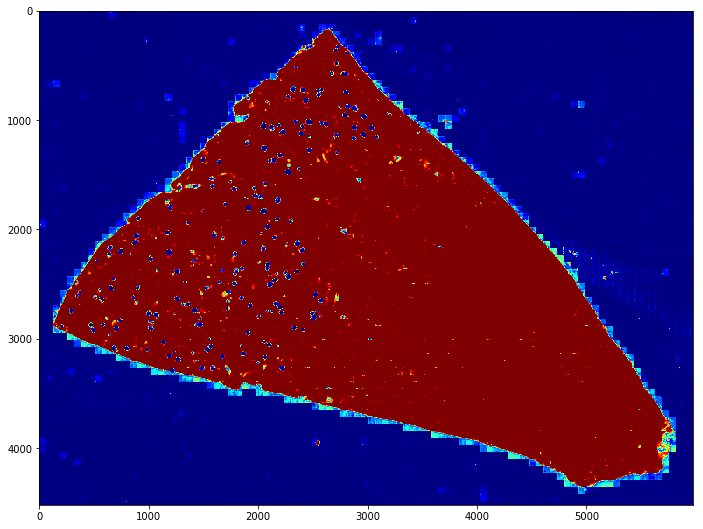

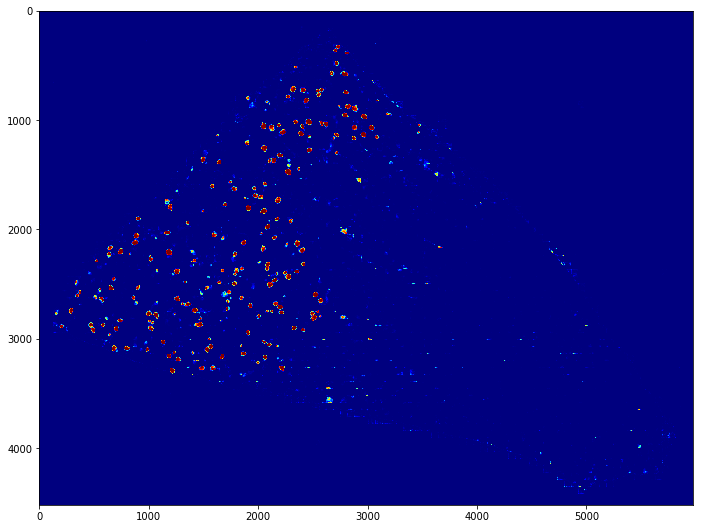

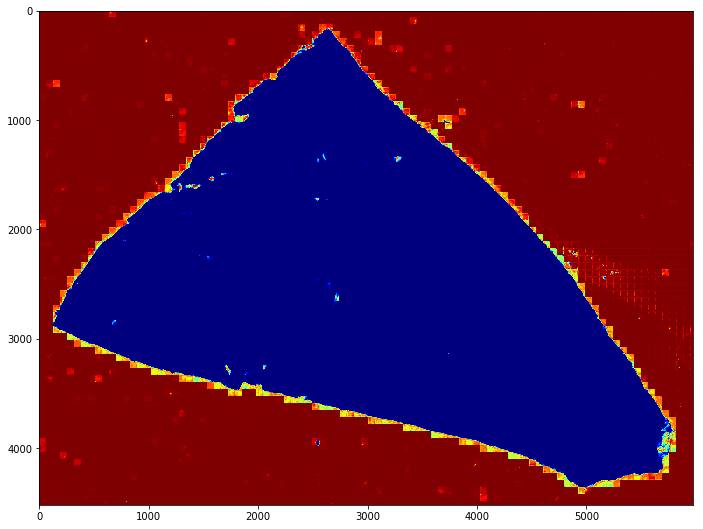

In [7]:
# Opening the file from extraction to get the mean and std used for training 
stats = matrice_file['stats'][:]
im_mean=stats[0]
im_std=stats[1]
matrice_file.close()

# Looping over the files of the folder coming from the config 
for file in files:
    # Creating the prediction folder that will contain our prediction.
    # The structure of the data for 1 trained network is as follows
    #           ____________________Experiment_1_________________   (main folder)
    #                /            /      |       \         \
    #           evaluation   graphs  matrices  model   prediction
    #            /              |       |         \          \
    #        IMAGE_NAME     "files"  "files"    "files"  IMAGE_NAME
    #           |                                          |     \
    #        "files"                                     proba  "files"
    #                                                     |
    #                                                  "files"
    output_folder = os.path.join(experiment_folder, "prediction", os.path.splitext(os.path.basename(file))[0])
    output_folder_jet = os.path.join(output_folder,"proba", "jet")
    output_folder_gray = os.path.join(output_folder,"proba", "grayscale")
    mkdirs(output_folder, 0o777)
    mkdirs(output_folder_jet, 0o777)
    mkdirs(output_folder_gray, 0o777)
    
    # Opening image 
    im = op.OpenSlide(file)
    imload = np.asfarray(im.read_region((0,0), load_level, im.level_dimensions[load_level]),dtype=np.float32)[:,:,0:color_channels]/255

    # Opening mask
    maskname = file_suffix(file, mask_pattern)
    maskload = Image.open(maskname)
    maskload = np.array(maskload.resize(im.level_dimensions[load_level]),dtype=np.float32)
    
    # Normalization with image info or training info
    if use_training_norm:
        imload-=im_mean
        imload/=im_std
    else:
        imload-=imload.mean()
        imload/=imload.std()

    # Starting clock to keep track of duration
    t0 = time.clock()
    

    # Creating array that will contain the prediction information
    output_proba = np.zeros((im.level_dimensions[load_level][1],im.level_dimensions[load_level][0],nb_classes),dtype=np.float32)

    
    stride = 64
    
    # The first method which is a lot faster (~5 times) only works on when the stride is the same as the patch_size
    # The whole image is fed in the network
    # /!\ It could be done to work with chosen stride, but you'll need to modify the code and keep in mind that you need to divide by how many times each pixel was predicted 
    
    # The second method works with stride, usually using stride = patch_size // 4. But it is a lot slower,
    # because the patches are fed one by one in the network
    
    if patch_size==stride:
        # Padding to have an image that can be divided by the patch_size to feed the network
        imload = np.lib.pad(imload[:,:,0:color_channels], ((0,patch_size-(imload.shape[0]%patch_size)), (0,patch_size-(imload.shape[1]%patch_size)),(0,0)), 'reflect')
        # Reshaping the image to follow this shape : (nb_patches_height, nb_patches_width, patch_size, patch_size, color_channels)
        imload_seg = view_as_blocks(imload,(patch_size,patch_size,color_channels))
        # Getting rid of a useless dimension created by the view_as_blocks
        imload_seg = imload_seg[:,:,0,:,:,:]

        # Reshaping image to feed it to the network (predict only takes 4 dimensions)
        # Shape will look as follows : (nb_patches, patch_size, patch_size, color_channels)
        xx = imload_seg.reshape((imload_seg.shape[0]*imload_seg.shape[1],imload_seg.shape[2],imload_seg.shape[3],imload_seg.shape[4]))

        # Getting the probability for each patches
        # If OOM try reducing the batch_size
        pred = UNet.predict(xx,batch_size=128)

        # Reshaping to original image shape
        temp = []
        j=0
        for i in range(imload_seg.shape[0]):
            temp.append(pred[j:j+imload_seg.shape[1]])
            j+=imload_seg.shape[1]
        pred = np.hstack(temp)
        temp = []
        for i in range(pred.shape[0]):
            temp.append(pred[i])
        pred = np.hstack(temp)

        # Creating a pointer on the area we just predicted
        part=output_proba[:,:]                                 
        # Filling the pointer with the information gathered from the prediction to 
        part[:,:]+=pred[0:part.shape[0],0:part.shape[1]]       

    else:
        # Creating array to keep track on how much time  if using stride != from 
        output_proba_times = np.zeros((im.level_dimensions[load_level][1],im.level_dimensions[load_level][0]),dtype=np.uint8)
    
        # Looping to extract patches one by one
        for pos_x in range(0,im.level_dimensions[load_level][0],stride):
            offset_x = pos_x+patch_size
            for pos_y in range(0,im.level_dimensions[load_level][1],stride):
                offset_y = pos_y+patch_size

                # Verifying if the patch is not exceeding the image border
                # If that is the case we offset to be exactly on the border
                if im.level_dimensions[load_level][1] < offset_y:
                    pos_y = im.level_dimensions[load_level][1]-patch_size
                    offset_y = pos_y+patch_size

                if im.level_dimensions[load_level][0] < offset_x:
                    pos_x = im.level_dimensions[load_level][0]-patch_size
                    offset_x = pos_x+patch_size
                
                # Expanding because predict takes 4 dimensions
                xx = np.expand_dims(imload[pos_y:offset_y ,pos_x:offset_x,:],0)

                pred = UNet.predict(xx)[0,:,:,:]

                part=output_proba[pos_y:offset_y,pos_x:offset_x]       # Creating a pointer on the patch area we just predicted
                part[:,:]+=pred[0:part.shape[0],0:part.shape[1]]       # Filling the pointer with the information gathered from the prediction
                output_proba_times[pos_y:offset_y,pos_x:offset_x]+=1   # Counting the amount of patches applying on every single pixel 
        
        #Dividing pixels' values by the number of times the patch passed on it    
        output_proba/=output_proba_times
    
    t = time.clock()
    print("Execution duration : ", t-t0)
    
    # Saving the output prediction for each classes
    for i in range(nb_classes):
        output_proba[:,:,i]
        
        if show_prediction:
            plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
            plt.subplot(211)
            plt.imshow(output_proba[:,:,i],interpolation='none', cmap="jet")
            plt.show()

        misc.imsave(os.path.join(output_folder_gray, "proba_gray_"+str(i)+".png"), output_proba[:,:,i])
        plt.imsave(os.path.join(output_folder_jet, "proba_jet_"+str(i)+".png"), output_proba[:,:,i], cmap=plt.cm.jet)

    # Saving the output prediction with an applied threshold (on glomeruli array)
    if threshold == -1:
        for t in np.arange(0.1,1.,0.1):
            save_threshold(t, output_proba[:,:,1], maskload)
    else:
        save_threshold(threshold, output_proba[:,:,1], maskload)